# Data Preparation

### Imports

In [66]:
import investpy
import yfinance as yf
import pandas as pd
import numpy as np
import requests

## US companies ticket extraction

In [5]:
us_stocks = investpy.stocks.get_stocks(country='united states')
us_stocks.to_csv('companies/us_stocks.csv', index=False)
print(us_stocks.head())

         country             name               full_name          isin  \
0  united states           Boeing               Boeing Co  US0970231058   
1  united states   General Motors  General Motors Company  US37045V1008   
2  united states          Chevron            Chevron Corp  US1667641005   
3  united states        Citigroup           Citigroup Inc  US1729674242   
4  united states  Bank of America    Bank of America Corp  US0605051046   

  currency symbol  
0      USD     BA  
1      USD     GM  
2      USD    CVX  
3      USD      C  
4      USD    BAC  


## Stocks price extraction from yahoo finance

In [ ]:
tickers = us_stocks['symbol'].tolist()

for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    try:
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(period="max")
        hist.to_csv(f"companies\\price\\{company[1]['name']}-{ticker}.csv", index=False)
        print(ticker)
    except Exception as e:
        print(e)

## Debt ratio extraction from FMP

In [ ]:
URL = "https://financialmodelingprep.com/api/v3/ratios/AAPL"

params = {
    'limit': '200',
    'apikey': '*'
}

for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        response = requests.get(URL, params=params)
        json_res = response.json()
        company_debtR_history = {"Date": [], "DebtRatio": []}
        for year_data in json_res:
            if year_data['debtRatio'] != 0:
                company_debtR_history["Date"].append(year_data['date'])
                company_debtR_history["DebtRatio"].append(year_data['debtRatio'])
        
        company_df = pd.DataFrame(company_debtR_history)
        company_df.to_csv(f"companies/debt/{company[1]['name']}-{ticker}.csv", index=False)
        print(ticker)
    except Exception as e:
        print(e)

## Concatenate close price of a stock with debt ratio

In [14]:
def merge_with_flexible_dates(stocks, debt, day_range=5):
    merged_data = []
    
    for debt_row in debt.itertuples():
        debt_date = debt_row.Date
        
        # Try to find exact match in stocks
        stock_match = stocks[stocks['Date'] == debt_date]
        
        if stock_match.empty:
            # If no exact match, find stock data within the 5-day window
            stock_match = stocks[
                (stocks['Date'] >= debt_date - pd.Timedelta(days=day_range)) &
                (stocks['Date'] <= debt_date + pd.Timedelta(days=day_range))
            ]
        
        if not stock_match.empty:
            # Take the closest date (min difference)
            closest_stock = stock_match.iloc[0]
            combined_row = {
                'Date': debt_date,
                'Close': closest_stock['Close'],
                'Debt': debt_row.DebtRatio
            }
            merged_data.append(combined_row)
    
    return pd.DataFrame(merged_data)

In [ ]:
for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        stocks = pd.read_csv(f"companies/price/{company[1]['name']}-{ticker}.csv")
        debt = pd.read_csv(f"companies/debt/{company[1]['name']}-{ticker}.csv")
        
        stocks['Date'] = pd.to_datetime(stocks['Date'], utc=True).dt.date
        debt['Date'] = pd.to_datetime(debt['Date']).dt.date
        debt = debt.sort_values(by='Date', ascending=True)
        
        combined_data = merge_with_flexible_dates(stocks, debt, day_range=2)
        only_close_debt = combined_data.dropna()
        
        if not only_close_debt.empty:
            print(ticker, company[1]['name'])
            only_close_debt.to_csv(f"companies/combined/{company[1]['name']}-{ticker}.csv", index=False)
    except Exception as e:
        print(e)

## Final concatenation

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
analysis_data = pd.DataFrame()
for company in us_stocks.iterrows():
    ticker = company[1]["symbol"]
    
    try:
        price_debt = pd.read_csv(f"companies/combined/{company[1]['name']}-{ticker}.csv")
        price_debt['Date'] = pd.to_datetime(price_debt['Date'])
        
        last_2_decades = price_debt[price_debt['Date'] >= pd.to_datetime("2003-01-01")]
        last_2_decades = last_2_decades.dropna()
        last_2_decades['Close_Percent_Change'] = last_2_decades['Close'].pct_change()
        
        if len(last_2_decades) >= 20:
            no_date_df = last_2_decades
            no_date_df['Close'] = scaler.fit_transform(no_date_df[['Close']])
            no_date_df['Company'] = company[1]['name']
            
            if analysis_data.empty:
                analysis_data = no_date_df
            else:
                analysis_data = pd.concat([analysis_data, no_date_df], axis=0)
            print(ticker, company[1]['name'])
    
    except Exception as e:
        print(e)

analysis_data.to_csv("companies/analysis_data.csv", index=False)

BA Boeing
CVX Chevron
C Citigroup
BAC Bank of America
T AT&T
CAT Caterpillar
INTC Intel
MSFT Microsoft
AA Alcoa
F Ford Motor
EBAY eBay
DIS Walt Disney
CSCO Cisco
DE Deere&Company
FDX FedEx
GIS General Mills
GLW Corning
GT The Goodyear Tire&Rubber
GS Goldman Sachs
JPM JPMorgan
KMB Kimberly-Clark
KO Coca-Cola
MCD McDonald’s
LLY Eli Lilly
ORCL Oracle
MRK Merck&Co
MSI Motorola
MMM 3M
ODP Office Depot
[Errno 2] No such file or directory: 'companies/combined/McKesson Europe-CAKFF.csv'
VRTX Vertex
MNST Monster Beverage
TEVA Teva ADR
FITB Fifth Third
[Errno 2] No such file or directory: 'companies/combined/Sears-SHLDQ.csv'
CTAS Cintas
ADSK Autodesk
[Errno 2] No such file or directory: 'companies/combined/DISH Network-DISH.csv'
GILD Gilead
[Errno 2] No such file or directory: 'companies/combined/aTyr Pharma-LIFE.csv'
GOOGL Alphabet A
LBTYA Liberty Global
[Errno 2] No such file or directory: 'companies/combined/PDL BioPharma-PDLI.csv'
ADBE Adobe
BB BlackBerry
QCOM Qualcomm
[Errno 2] No such file

# Analysis

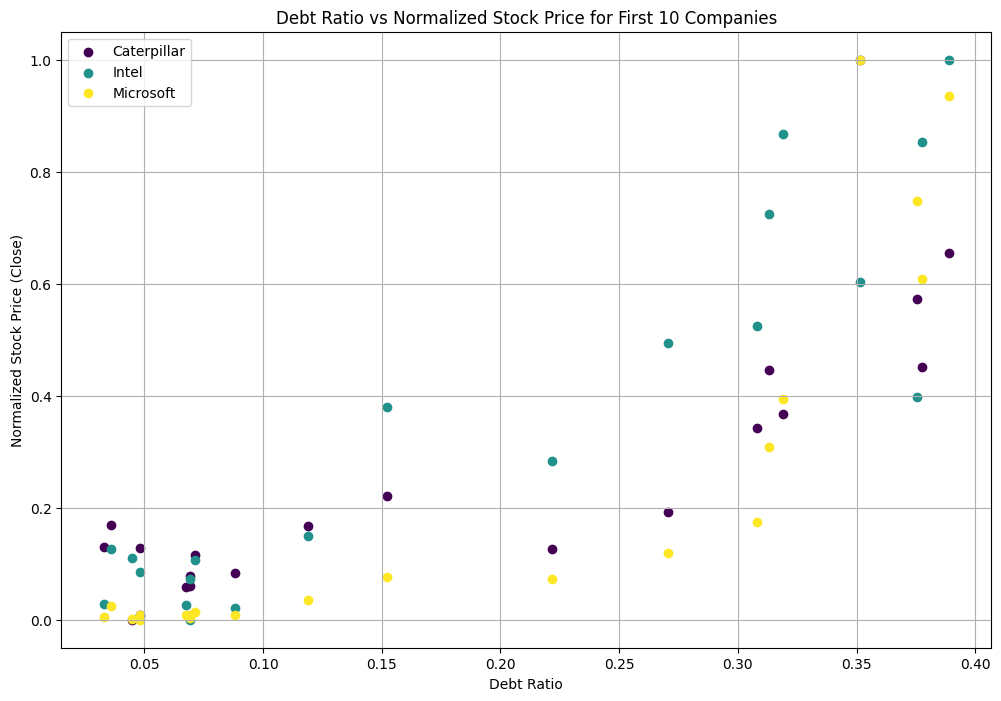

In [76]:
import matplotlib.pyplot as plt

analysis_data = pd.read_csv("companies/analysis_data.csv")

unique_companies = analysis_data['Company'].unique()[5:8]  # Get the first 10 unique companies
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_companies)))  # Generate colors

plt.figure(figsize=(12, 8))

# Step 3: Scatter Plot
for i, company in enumerate(unique_companies):
    company_data = analysis_data[analysis_data['Company'] == company]
    plt.scatter(company_data['Debt'], company_data['Close'], 
                color=colors[i], label=company)

# Step 4: Customize the plot
plt.title('Debt Ratio vs Normalized Stock Price for First 10 Companies')
plt.xlabel('Debt Ratio')
plt.ylabel('Normalized Stock Price (Close)')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
correlation_results = pd.DataFrame(columns=['Company', 'Correlation'])

correlation_results = []

for company, group in analysis_data.groupby('Company'):
    group = group.dropna(subset=['Debt', 'Close'])
    correlation = group['Debt'].corr(group['Close'])
    correlation_results.append({'Company': company, 'Correlation': correlation})

correlation_results_df = pd.DataFrame(correlation_results)

print("All companies with counted correlation: ", len(correlation_results_df))
correlation_results_df

All companies with counted correlation:  1882


,Company,Correlation
0,1-800 FLOWERS.COM,0.634649
1,1st Source,0.922311
2,3D Systems,0.077757
3,3M,0.873181
4,8x8,0.697409
...,...,...
1877,eBay,0.897925
1878,eGain,0.600516
1879,ePlus,0.936724
1880,icad,-0.456465


In [86]:
only_strong_corr = correlation_results_df[(correlation_results_df['Correlation'] > 0.7) | (correlation_results_df['Correlation'] < -0.7)]
only_strong_corr

,Company,Correlation
1,1st Source,0.922311
3,3M,0.873181
5,AAON,0.917731
6,AAR,0.750695
8,ABM Industries,0.967208
...,...,...
1873,Zimmer Biomet,0.945968
1875,Zurich Insurance Group,0.915771
1876,bebe stores,-0.709585
1877,eBay,0.897925


In [88]:
from scipy import stats

def calculate_correlation_significance(r, n):
    # Calculate t-statistic
    t = r * ((n - 2) ** 0.5) / ((1 - r ** 2) ** 0.5)
    # Calculate p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t), df=n - 2))  # Two-tailed test
    return p_value

correlation_results_df['p_value'] = correlation_results_df.apply(lambda row: calculate_correlation_significance(row['Correlation'], len(analysis_data[analysis_data['Company'] == row['Company']])), axis=1)

significant_correlations = correlation_results_df[correlation_results_df['p_value'] < 0.05]

significant_correlations

,Company,Correlation,p_value
0,1-800 FLOWERS.COM,0.634649,1.998777e-03
1,1st Source,0.922311,2.774375e-09
3,3M,0.873181,2.394795e-07
4,8x8,0.697409,4.412514e-04
5,AAON,0.917731,4.694137e-09
...,...,...,...
1877,eBay,0.897925,3.366404e-08
1878,eGain,0.600516,3.996198e-03
1879,ePlus,0.936724,4.181104e-10
1880,icad,-0.456465,3.752657e-02


In [90]:
combined_corr_df = pd.merge(significant_correlations, only_strong_corr, on='Company', how='inner')
combined_corr_df

,Company,Correlation_x,p_value,Correlation_y
0,1st Source,0.922311,2.774375e-09,0.922311
1,3M,0.873181,2.394795e-07,0.873181
2,AAON,0.917731,4.694137e-09,0.917731
3,AAR,0.750695,8.830121e-05,0.750695
4,ABM Industries,0.967208,9.148238e-13,0.967208
...,...,...,...,...
1101,Zimmer Biomet,0.945968,9.673196e-11,0.945968
1102,Zurich Insurance Group,0.915771,5.825338e-09,0.915771
1103,bebe stores,-0.709585,3.150708e-04,-0.709585
1104,eBay,0.897925,3.366404e-08,0.897925


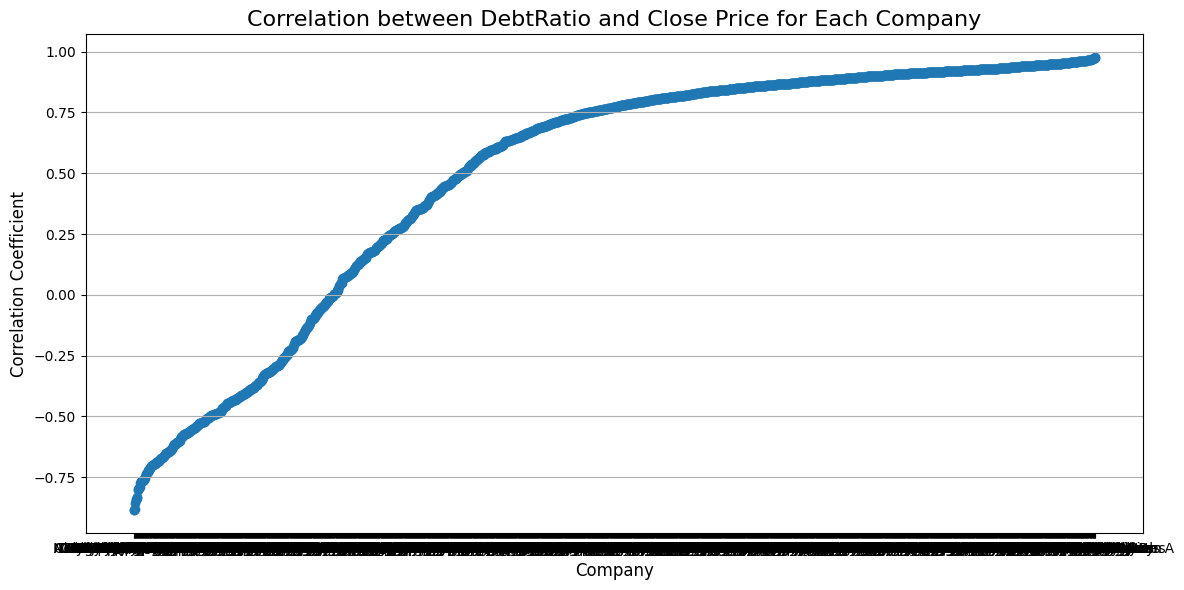

In [94]:
import seaborn as sns

sorted_correlation_df = correlation_results_df.sort_values(by='Correlation', ascending=True)

plt.figure(figsize=(12, 6))

# Create a bar plot
plt.scatter(sorted_correlation_df["Company"], sorted_correlation_df["Correlation"])

# Set titles and labels
plt.title('Correlation between DebtRatio and Close Price for Each Company', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

# Show grid lines
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()